In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import xgboost
from xgboost import XGBClassifier
import time
from sklearn.model_selection import KFold
%matplotlib inline

### 1.EDA

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv')
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# 欠損値確認
dataset.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
dataset['TotalCharges'] = dataset['TotalCharges'].apply(pd.to_numeric,errors='coerce')

In [6]:
#Create a label encoder object
le = LabelEncoder()

for col in dataset.columns[1:]:
  if dataset[col].dtype == 'object':
    if len(list(dataset[col].unique())) <= 2:
      le.fit(dataset[col])
      dataset[col] = le.transform(dataset[col]) 

In [7]:
corr = dataset.corr()

Text(0.5, 1.0, 'Correlation between variables')

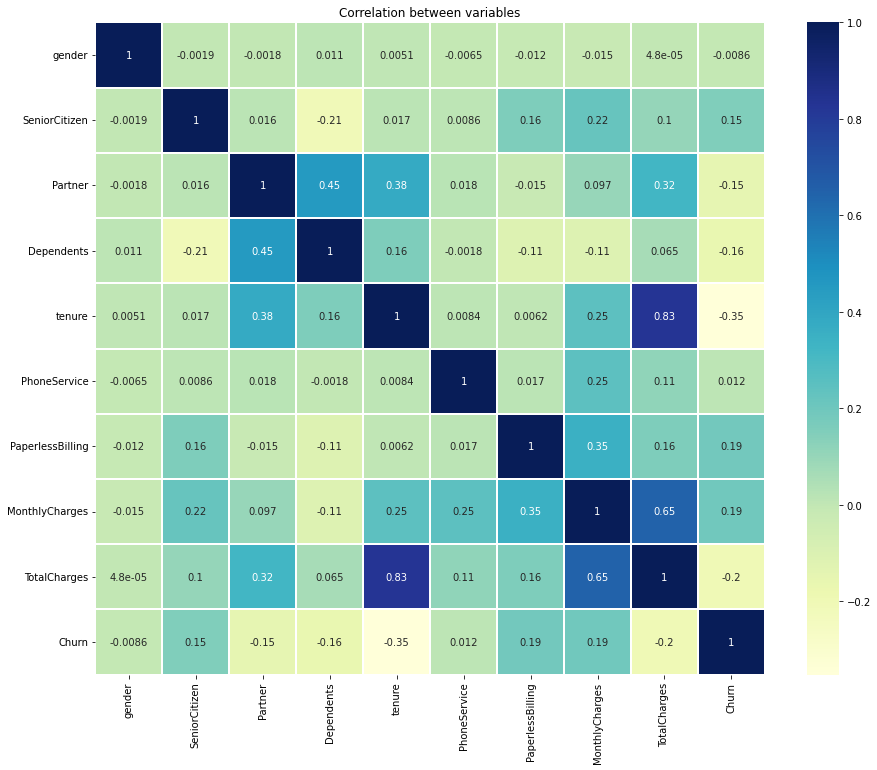

In [8]:
plt.figure(figsize=(15,12))
ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=0.2,cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")

In [9]:
dataset_dummies = pd.get_dummies(dataset.iloc[:,1:21])
dataset_dummies.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


<AxesSubplot:>

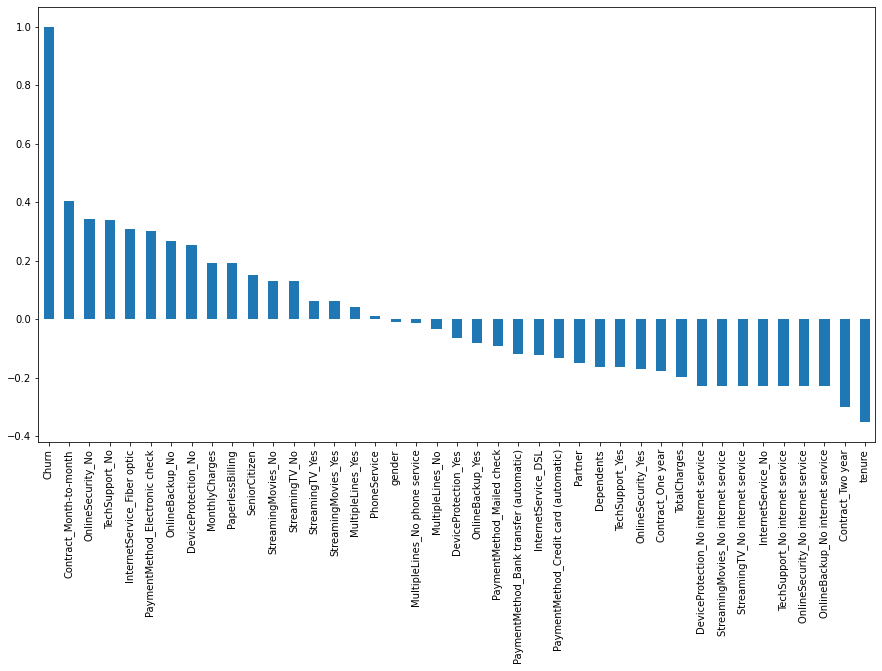

In [10]:
plt.figure(figsize=(15,8))
dataset_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

<AxesSubplot:xlabel='Contract', ylabel='Churn'>

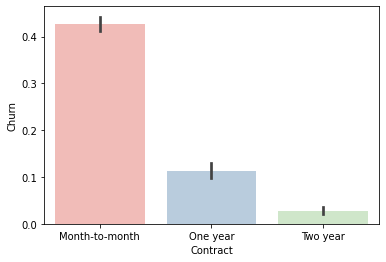

In [11]:
sns.barplot(x="Contract",y="Churn",data=dataset,palette="Pastel1",order= ['Month-to-month', 'One year', 'Two year'])

In [12]:
dataset.drop(["gender","PhoneService"],axis=1,inplace=True)

In [13]:
dataset_var = dataset.iloc[:,1:]

In [14]:
dataset_var.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,34,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [15]:
## 標準化
scaler = StandardScaler(copy=False)
scaler.fit_transform(dataset_var[['tenure','MonthlyCharges','TotalCharges']])

array([[-1.27744458, -1.16032292, -0.99419409],
       [ 0.06632742, -0.25962894, -0.17373982],
       [-1.23672422, -0.36266036, -0.95964911],
       ...,
       [-0.87024095, -1.1686319 , -0.85451414],
       [-1.15528349,  0.32033821, -0.87209546],
       [ 1.36937906,  1.35896134,  2.01234407]])

In [16]:
dataset_var[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(dataset_var[['tenure','MonthlyCharges','TotalCharges']])

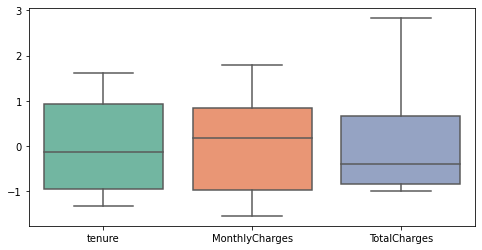

In [17]:
plt.figure(figsize = (8,4))
numbox = sns.boxplot(data=dataset_var[['tenure','MonthlyCharges','TotalCharges']],palette="Set2")


### 2.データの前処理

In [18]:
# 不要な項目は変換する
dataset_var.replace(to_replace='No internet service',value='No',inplace=True)
dataset_var.replace(to_replace='No phone service',value='No',inplace=True)

In [19]:
# カテゴリカル変数をencoding
def encode_categorical(df,cols):
  for col in cols:
    le = LabelEncoder()
    df[col] = pd.Series(le.fit_transform(df[col]))

  return df

dataset_encoded = encode_categorical(dataset_var,cols=['SeniorCitizen','Partner','Dependents','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'])
dataset_encoded = dataset_encoded.dropna()

###3.訓練/テストデータ分割

In [20]:
X = dataset_encoded.drop('Churn',axis=1)
y = dataset_encoded['Churn'].values

sss = StratifiedShuffleSplit(n_splits=5,test_size=0.1,random_state=0)

In [21]:
for train_index,test_index in sss.split(X,y):
  X_train,X_test = X.iloc[train_index],X.iloc[test_index]
  y_train,y_test = y[train_index],y[test_index]

### 4.モデル構築

In [22]:
xg = XGBClassifier(
    eta = 0.1,
    max_depth=5,
    min_child_weight=1,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=0,
    alpha=0
)
xg.fit(X_train,y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
seed = 42
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }
cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定
scoring = 'neg_mean_squared_error'

In [ ]:
from sklearn.model_selection import GridSearchCV
start = time.time()
# 最終的なパラメータ範囲
cv_params = {'eta': [0.01, 0.03, 0.1, 0.3],
             'min_child_weight': [1, 2, 3, 4, 5],
             'max_depth': [3, 5, 7, 9],
             'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
             'gamma': [.0, .1, .2, .3, .4],
             'alpha': [1e-5,1e-2,0.1,1,100]
             }
# グリッドサーチのインスタンス作成
gridcv = GridSearchCV(xg, cv_params, cv=cv,
                      scoring=scoring, n_jobs=-1)
# グリッドサーチ実行（学習実行）
gridcv.fit(X_train, y_train, **fit_params)
# 最適パラメータの表示と保持
best_params = gridcv.best_params_
best_score = gridcv.best_score_
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

In [ ]:
xg = XGBClassifier(
    booster="gbtree",
    learning_rate = 0.1,
    min_child_weight = 8,
    max_depth = 3,
    colsample_bytree = 0.2,
    subsample = 0.8
)
xg.fit(X_train,y_train)

In [ ]:
xg.score(X_test,y_test)

In [ ]:
from sklearn import metrics
y_pred = xg.predict_proba(X_test)

In [ ]:
import matplotlib.pyplot as plt
xg.feature_importances_
plt.barh(X.columns,xg.feature_importances_)